# Self-classifying MNIST Digits

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import json
import os

import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.update.residual_update import ResidualUpdate
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [2]:
seed = 0

channel_size = 32
num_spatial_dims = 1
num_kernels = 2
hidden_size = 256
cell_dropout_rate = 0.5

batch_size = 8
num_steps = 128
learning_rate = 1e-3

task = "1d_move_dp"

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

2024-09-28 11:45:07.153779: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Dataset

In [3]:
ds_path = "/home_nfs/maxence/projects/cax/arc/"
ds_size = 128
train_tasks = {}
test_tasks = {}

for task_name in os.listdir(ds_path):
	task_path = os.path.join(ds_path, task_name)
	train_examples = []
	test_examples = []

	for task_file in os.listdir(task_path):
		task_file_path = os.path.join(task_path, task_file)
		with open(task_file_path) as f:
			data = json.load(f)
			for split in ["train", "test"]:
				for example in data[split]:
					input = jnp.squeeze(jnp.array(example["input"], dtype=jnp.int32))
					output = jnp.squeeze(jnp.array(example["output"], dtype=jnp.int32))

					assert input.shape == output.shape

					# Pad arrays to pad_size
					pad_size = ds_size - input.size
					pad_left = pad_size // 2
					pad_right = pad_size - pad_left

					input_padded = jnp.pad(input, (pad_left, pad_right))
					output_padded = jnp.pad(output, (pad_left, pad_right))

					# Concatenate input and output
					example_array = jnp.expand_dims(jnp.concatenate([input_padded, output_padded]), axis=-1)

					if split == "train":
						train_examples.append(example_array)
					else:
						test_examples.append(example_array)

	train_tasks[task_name] = jnp.array(train_examples)
	test_tasks[task_name] = jnp.array(test_examples)

In [4]:
def init_state(key):
	input, target = jnp.split(jax.random.choice(key, train_tasks[task]), indices_or_sections=2)
	state = jnp.zeros((ds_size, channel_size))
	state = state.at[..., :1].set(input)
	return state, target


def init_state_test(key):
	input, target = jnp.split(jax.random.choice(key, test_tasks[task]), indices_or_sections=2)
	state = jnp.zeros((ds_size, channel_size))
	state = state.at[..., :1].set(input)
	return state, target

## Model

In [5]:
perceive = DepthwiseConvPerceive(channel_size, rngs, num_kernels=num_kernels, kernel_size=(3,))
update = ResidualUpdate(
	num_spatial_dims,
	channel_size,
	num_kernels * channel_size,
	(hidden_size,),
	rngs,
	cell_dropout_rate=cell_dropout_rate,
)
embed = nnx.Embed(num_embeddings=10, features=3, rngs=rngs)


class EmbedCA(CA):
	embed: nnx.Embed

	def __init__(self, perceive, update, embed):
		super().__init__(perceive, update)

		self.embed = embed

In [6]:
kernel = jnp.concatenate([identity_kernel(ndim=1), grad_kernel(ndim=1)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [7]:
ca = EmbedCA(perceive, update, embed)

In [8]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 25086


## Train

In [9]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [10]:
def mse(state, target):
	return jnp.mean(jnp.square(state[..., :3] - target))

In [11]:
@nnx.jit
def loss_fn(ca, state, target):
	# Embed
	input = state[..., 0]
	input_embed = ca.embed(jnp.asarray(input, dtype=jnp.int32))
	state = state.at[..., :3].set(input_embed)

	target_embed = ca.embed(jnp.asarray(target[..., 0], dtype=jnp.int32))

	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	loss = mse(state, target_embed)
	return loss

### Train step

In [12]:
@nnx.jit
def train_step(ca, optimizer, key):
	keys = jax.random.split(key, batch_size)
	state, target = jax.vmap(init_state)(keys)

	loss, grad = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, update_params))(ca, state, target)
	optimizer.update(grad)
	return loss

### Main loop

In [13]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []

for i in pbar:
	key, subkey = jax.random.split(key)
	loss = train_step(ca, optimizer, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.6f}"})

Training:   0%|          | 0/8192 [00:00<?, ?train_step/s]

KeyboardInterrupt: 

## Visualize

In [14]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 8)
state_init, target = jax.vmap(init_state_test)(keys)

input = state_init[..., 0]
input_embed = ca.embed(jnp.asarray(input, dtype=jnp.int32))
state_init = state_init.at[..., :3].set(input_embed)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=batch_size)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
		in_axes=(state_axes, 0),
	)
)(ca, state_init)

# state = jnp.concatenate([jnp.expand_dims(state_init, axis=1), state], axis=1)
state_rgb = jnp.concatenate([jnp.expand_dims(state_init[..., :3], axis=1), state[..., :3]], axis=1)

### 1d_pcopy_mc

,,,,,,,

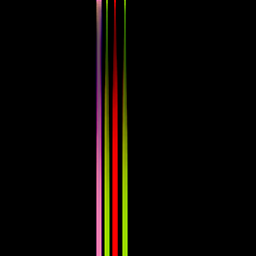
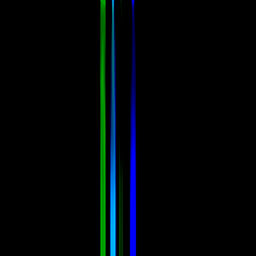
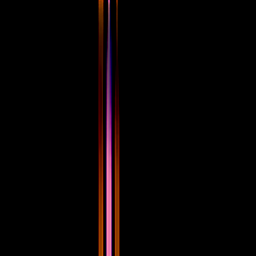
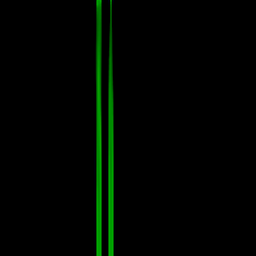
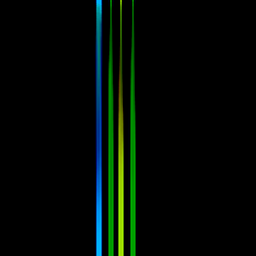
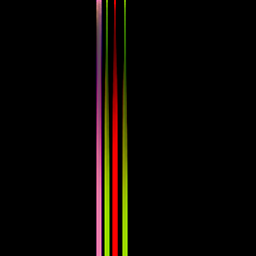
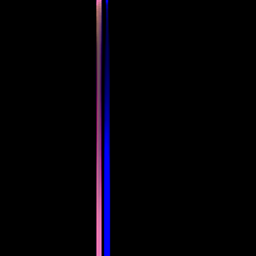
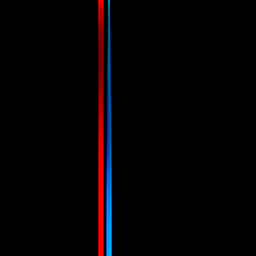

In [123]:
mediapy.show_images(state_rgb, width=256, height=256)

### 1d_recolor_cmp

,,,,,,,

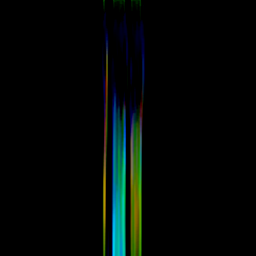
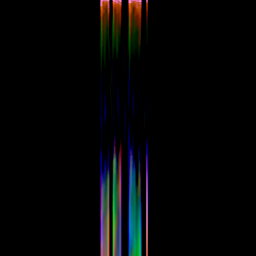
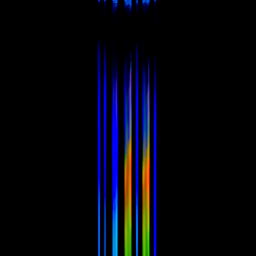
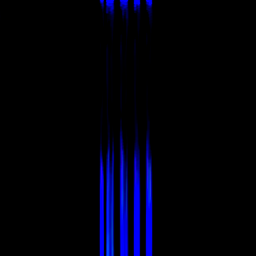
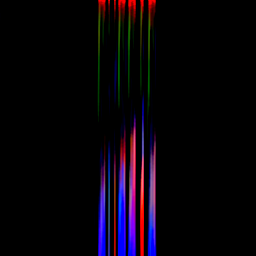
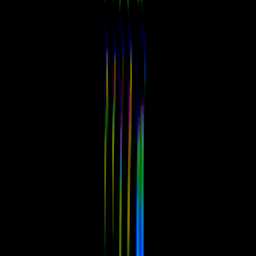
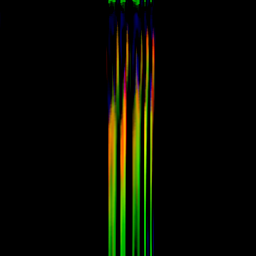
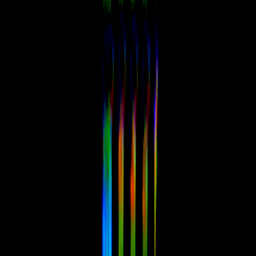

In [94]:
mediapy.show_images(state_rgb, width=256, height=256)

,,,,,,,

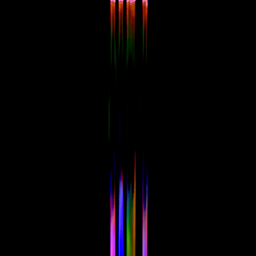
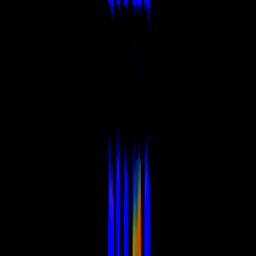
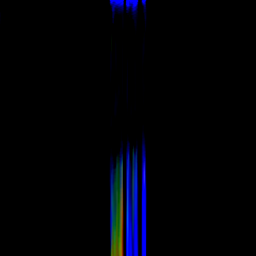
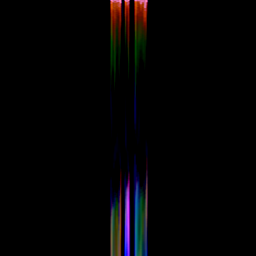
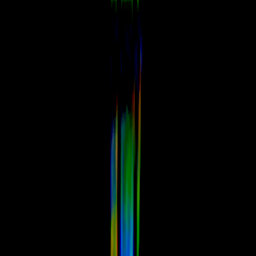
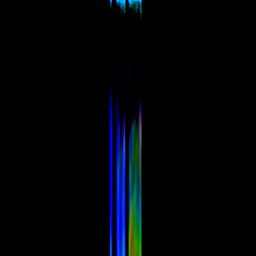
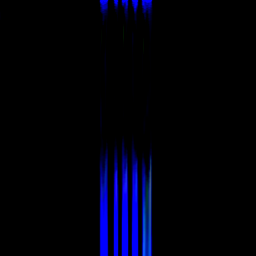
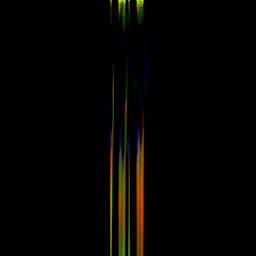

In [89]:
mediapy.show_images(state_rgb, width=256, height=256)

### 1d_mirror

,,,,,,,

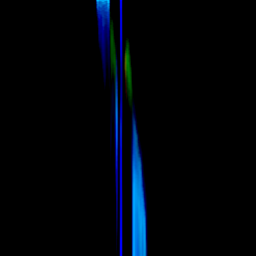
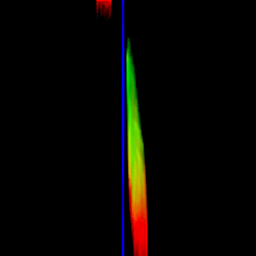
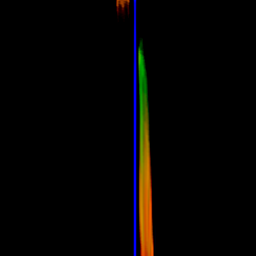
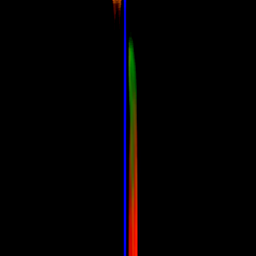
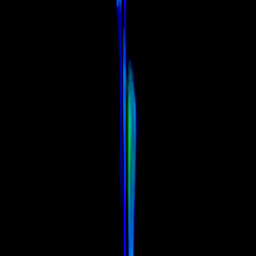
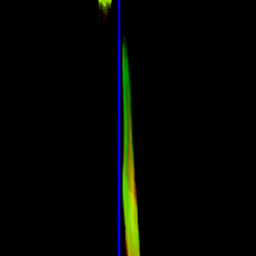
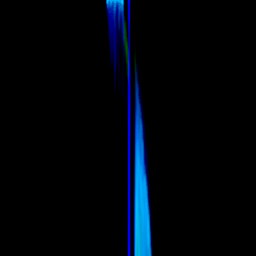
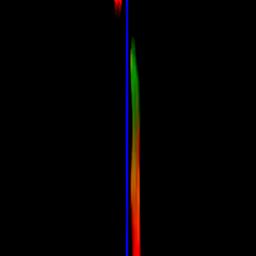

In [59]:
mediapy.show_images(state_rgb, width=256, height=256)

### 1d_padded_fill

,,,,,,,

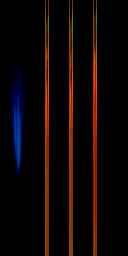
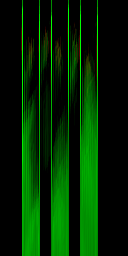
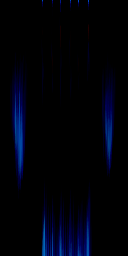
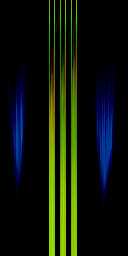
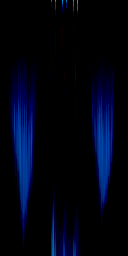
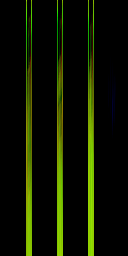
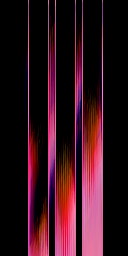
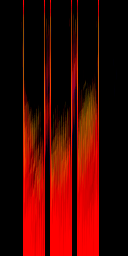

In [40]:
mediapy.show_images(state_rgb, width=256, height=256)

### 1d_move_dp

,,,,,,,

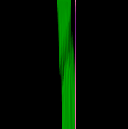
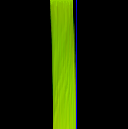
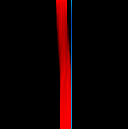
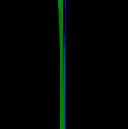
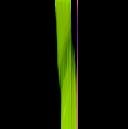
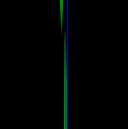
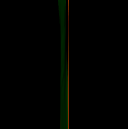
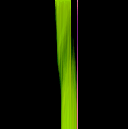

In [18]:
mediapy.show_images(state_rgb, width=256, height=256)

,,,,,,,

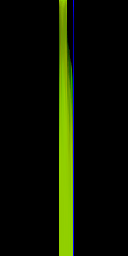
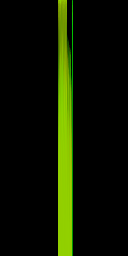
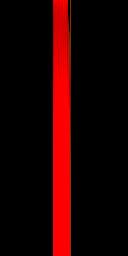
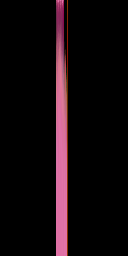
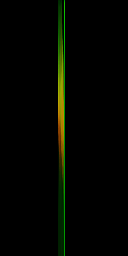
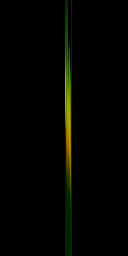
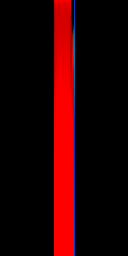
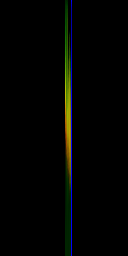

In [25]:
mediapy.show_images(state_rgb, width=256, height=256)

In [180]:
color_map = (
	jnp.array(
		[
			[0, 0, 0],
			[255, 192, 203],
			[0, 255, 0],
			[255, 0, 0],
			[128, 128, 128],
			[0, 0, 255],
			[255, 255, 0],
			[255, 165, 0],
			[173, 216, 230],
			[139, 0, 0],
		]
	)
	/ 255
)

state_int = jnp.asarray(jnp.clip(jnp.round(state[..., 0]), 0, 9), dtype=jnp.int32)
state_color = jnp.take(color_map, state_int, axis=-1)

In [181]:
state_rgb = color_map[state_int]

,,,,,,,

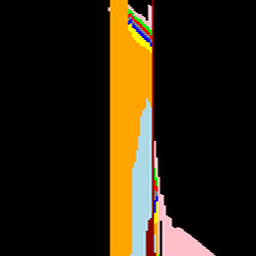
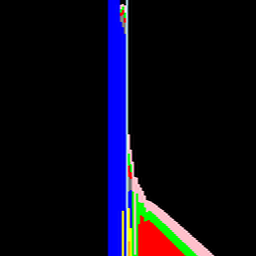
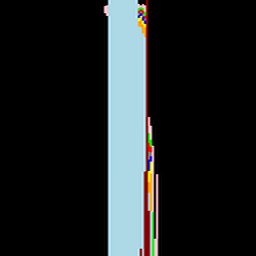
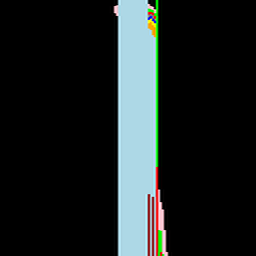
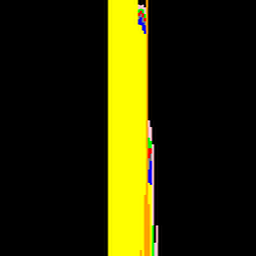
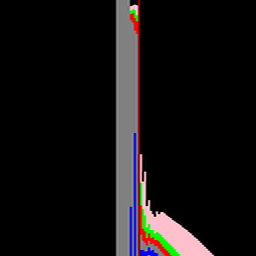
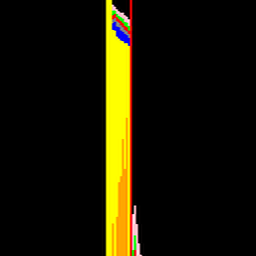
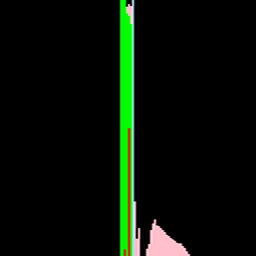

In [182]:
mediapy.show_images(state_rgb, width=256, height=256)